### Train and tune LGBM using ADS ADSTuner

see: https://accelerated-data-science.readthedocs.io/en/latest/user_guide/model_training/ads_tuner.html#

* https://lightgbm.readthedocs.io/en/v3.3.2/
* applicato al caso **customer churn**
* usa: generalml_ come ambiente conda
* (23/03): switched to p38

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import imblearn

from sklearn.metrics import classification_report
from sklearn.metrics import (get_scorer, make_scorer, f1_score, roc_auc_score, accuracy_score, 
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# ADS tuner
from ads.hpo.distributions import *
from ads.hpo.search_cv import ADSTuner
from ads.hpo.stopping_criterion import *

# to rebalance
from imblearn.over_sampling import RandomOverSampler

from utils import (cat_cols_selector,
                  num_cols_selector,
                  plot_cm,
                  evaluate_metrics)

%matplotlib inline

#### Legge i dati dall'Object Storage

In [2]:
NAMESPACE = "frqap2zhtzbe"
BUCKET = "WORKSHOP"
NOME_FILE = "customer_churn_data.csv"

URL = f"oci://{BUCKET}@{NAMESPACE}/{NOME_FILE}"

orig_df = pd.read_csv(URL)

orig_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Data Preparation, Feature Engineering

In [3]:
# get rid of some columns
cols_to_drop = ['customerID', 'TotalCharges']

df = orig_df.drop(columns=cols_to_drop)

TARGET = "Churn"
features = list(set(df.columns) - set([TARGET]))

In [4]:
# identify categorical and continuous
cat_cols = cat_cols_selector(df, TARGET)
num_cols = num_cols_selector(df, TARGET)

In [5]:
# code categorical as integer for LightGBM
enc = OrdinalEncoder()
enc.fit(df[cat_cols])

df[cat_cols] = enc.transform(df[cat_cols])

for col in cat_cols:
    df[col] = df[col].astype("category")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   category
 1   SeniorCitizen     7043 non-null   category
 2   Partner           7043 non-null   category
 3   Dependents        7043 non-null   category
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   InternetService   7043 non-null   category
 8   OnlineSecurity    7043 non-null   category
 9   OnlineBackup      7043 non-null   category
 10  DeviceProtection  7043 non-null   category
 11  TechSupport       7043 non-null   category
 12  StreamingTV       7043 non-null   category
 13  StreamingMovies   7043 non-null   category
 14  Contract          7043 non-null   category
 15  PaperlessBilling  7043 non-null   category
 16  PaymentMethod     7043 n

In [7]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,0.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,29.85,No
1,1.0,0.0,0.0,0.0,34,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,56.95,No
2,1.0,0.0,0.0,0.0,2,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,53.85,Yes
3,1.0,0.0,0.0,0.0,45,0.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,42.30,No
4,0.0,0.0,0.0,0.0,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,70.70,Yes


#### Train/test split

In [8]:
# train, test split (lo faccio direttamente sui dataframe)
SEED = 42

TEST_FRAC = 0.2

df_train, df_test = train_test_split(df, shuffle=True, test_size=TEST_FRAC, 
                                     random_state = SEED)

X_train, y_train = df_train.drop([TARGET], axis=1), df_train[TARGET]
X_test, y_test = df_test.drop([TARGET], axis=1), df_test[TARGET]

print()
print("Summary on train/test dataset:")
print()
print("# of samples in train set", df_train.shape[0])
print("# of samples in test set", df_test.shape[0])
print()
print(f'Numerical columns: {num_cols} ({len(num_cols)})')
print()
print(f'Categorical columns: {cat_cols} ({len(cat_cols)})')


Summary on train/test dataset:

# of samples in train set 5634
# of samples in test set 1409

Numerical columns: ['tenure', 'MonthlyCharges'] (2)

Categorical columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'] (16)


#### HPO sul dataset non bilanciato

In [9]:
#
# definisco la pipeline completa
#
N_TRIALS = 50

# metrics on which to optimize
scorer = make_scorer(accuracy_score)

# i parametri che vogliamo fissare
params = {
    # info
    "verbose" : 0,
}

# qui definisco la strategia per HPO
strategy = {"num_leaves" : IntUniformDistribution(5, 24, 1),
           'max_depth': IntUniformDistribution(2, 10, 1),
            'n_estimators': IntUniformDistribution(50, 200, 10),
            'learning_rate' : LogUniformDistribution(low=1e-03, high=1e-1),
            }

# non abbiamo bisogno di scalare perchè è un GBM
model = lgb.LGBMClassifier(**params)

In [10]:
tuner = ADSTuner(model, cv=5, n_jobs=2, strategy=strategy, scoring=scorer, random_state=SEED)

tuner.tune(X_train, y_train, exit_criterion=[NTrials(N_TRIALS)])

[I 2023-03-23 10:35:22,376] A new study created in RDB with name: hpo_7ee7e7cc-cad5-4cf5-9280-f1646b46795c


In [27]:
print(f"Number of trials launched: {len(tuner.trials)}")

Number of trials launched: 50


In [26]:
tuner.trials.sort_values(by=["value"], ascending=False).head()

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,params_num_leaves,user_attrs_mean_fit_time,...,user_attrs_metric,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_split3_test_score,user_attrs_split4_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
29,29,0.803691,2023-03-23 10:36:53.174307,2023-03-23 10:36:59.142035,0 days 00:00:05.967728,0.033484,4,90,23,1.127427,...,accuracy_score,0.814552,0.810115,0.797693,0.796806,0.799290,0.007376,0.003013,0.007239,COMPLETE
17,17,0.803158,2023-03-23 10:36:16.439860,2023-03-23 10:36:21.889128,0 days 00:00:05.449268,0.041221,4,80,21,1.027936,...,accuracy_score,0.813665,0.809228,0.802130,0.794144,0.796625,0.010378,0.001448,0.007379,COMPLETE
18,18,0.802804,2023-03-23 10:36:21.906293,2023-03-23 10:36:26.653979,0 days 00:00:04.747686,0.034418,4,70,21,0.891400,...,accuracy_score,0.813665,0.808341,0.795031,0.795031,0.801954,0.007531,0.002326,0.007351,COMPLETE
32,32,0.802804,2023-03-23 10:37:03.870810,2023-03-23 10:37:09.298028,0 days 00:00:05.427218,0.034016,4,80,24,1.029777,...,accuracy_score,0.814552,0.810115,0.794144,0.795918,0.799290,0.025967,0.002569,0.008078,COMPLETE
46,46,0.802803,2023-03-23 10:37:47.265164,2023-03-23 10:37:49.429748,0 days 00:00:02.164584,0.073852,2,90,22,0.372319,...,accuracy_score,0.816327,0.811003,0.794144,0.795031,0.797513,0.007321,0.002488,0.009094,COMPLETE


In [28]:
tuner.status

<State.COMPLETED: 5>

In [29]:
tuner.best_params

{'learning_rate': 0.03348447566292928,
 'max_depth': 4,
 'n_estimators': 90,
 'num_leaves': 23}

#### Addestriamo il modello con i best params

In [30]:
params = tuner.best_params

model = lgb.LGBMClassifier(**params)

In [31]:
model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.03348447566292928, max_depth=4, n_estimators=90,
               num_leaves=23)

#### Evaluation

In [32]:
metrics = evaluate_metrics(model, X_test, y_test)

Validation set result:
{'accuracy': 0.8119, 'roc_auc': 0.8622, 'recall': 0.5174}


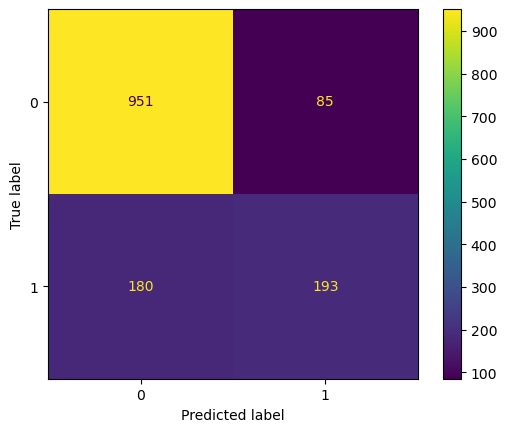

In [33]:
plot_cm(model, X_test, y_test)

#### Rebalance: vediamo che bilanciando il dataset si ottiene un risultato migliore riducendo i FN

In [34]:
SEED = 42

# we use a simple RandomSampler from imblearn
ros = RandomOverSampler(random_state=SEED)

In [35]:
# bilanciamo solo il training set, il test set NON è toccato
X_train_reb, y_train_reb = ros.fit_resample(X_train, y_train)

In [36]:
params = {
    # info
    "verbose" : 0,
}

strategy = {"num_leaves" : IntUniformDistribution(15, 24, 1),
            'max_depth': IntUniformDistribution(5, 15, 1),
            'n_estimators': IntUniformDistribution(50, 200, 10),
            'learning_rate' : LogUniformDistribution(low=1e-03, high=1e-1),
            }

model = lgb.LGBMClassifier(**params)

In [37]:
tuner = ADSTuner(model, cv=5, n_jobs=2, strategy=strategy, scoring=scorer, random_state=SEED)

tuner.tune(X_train_reb, y_train_reb, exit_criterion=[NTrials(N_TRIALS)])

In [68]:
print(f"Number of trials launched: {len(tuner.trials)}")

Number of trials launched: 50


In [69]:
tuner.trials.sort_values(by=["value"], ascending=False).head()

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,params_num_leaves,user_attrs_mean_fit_time,...,user_attrs_metric,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_split3_test_score,user_attrs_split4_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
13,13,0.828181,2023-03-23 10:45:16.119187,2023-03-23 10:45:33.766817,0 days 00:00:17.647630,0.094897,7,160,24,3.460370,...,accuracy_score,0.800121,0.824169,0.829003,0.837462,0.850151,0.030518,0.003457,0.016571,COMPLETE
43,43,0.827698,2023-03-23 10:49:21.082334,2023-03-23 10:49:37.834681,0 days 00:00:16.752347,0.099726,6,180,21,3.283772,...,accuracy_score,0.800725,0.818127,0.824773,0.843505,0.851360,0.055107,0.002515,0.018097,COMPLETE
24,24,0.827577,2023-03-23 10:46:42.523281,2023-03-23 10:46:59.888698,0 days 00:00:17.365417,0.092818,6,170,24,3.410708,...,accuracy_score,0.803140,0.813293,0.832628,0.839275,0.849547,0.060840,0.003319,0.017007,COMPLETE
15,15,0.827214,2023-03-23 10:45:32.891182,2023-03-23 10:45:48.979450,0 days 00:00:16.088268,0.097078,8,150,22,3.154206,...,accuracy_score,0.802536,0.821148,0.827190,0.833837,0.851360,0.048671,0.003239,0.015954,COMPLETE
22,22,0.827093,2023-03-23 10:46:25.845921,2023-03-23 10:46:42.509822,0 days 00:00:16.663901,0.095017,7,150,24,3.269958,...,accuracy_score,0.807971,0.816918,0.829607,0.833233,0.847734,0.051220,0.003804,0.013706,COMPLETE


In [70]:
tuner.best_params

{'learning_rate': 0.09489714884434745,
 'max_depth': 7,
 'n_estimators': 160,
 'num_leaves': 24}

In [71]:
params = tuner.best_params

model = lgb.LGBMClassifier(**params)

In [72]:
model.fit(X_train_reb, y_train_reb)

LGBMClassifier(learning_rate=0.09489714884434745, max_depth=7, n_estimators=160,
               num_leaves=24)

In [73]:
metrics = evaluate_metrics(model, X_test, y_test)

Validation set result:
{'accuracy': 0.7708, 'roc_auc': 0.8501, 'recall': 0.7748}


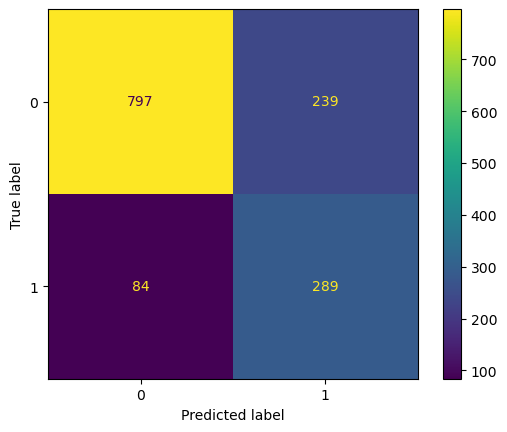

In [74]:
plot_cm(model, X_test, y_test)

#### Some plots

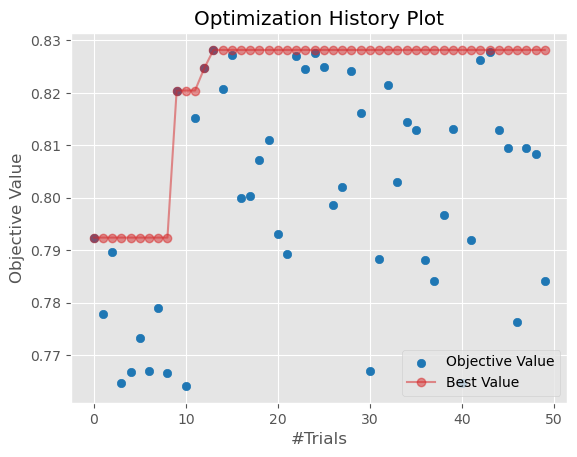

In [75]:
tuner.plot_best_scores()

In [76]:
tuner.search_space()

{'num_leaves': IntUniformDistribution(low=15, high=24, step=1),
 'max_depth': IntUniformDistribution(low=5, high=15, step=1),
 'n_estimators': IntUniformDistribution(low=50, high=200, step=10),
 'learning_rate': LogUniformDistribution(low=0.001, high=0.1)}

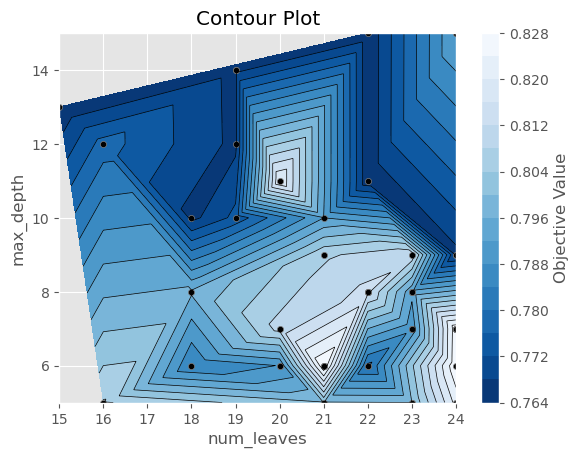

In [77]:
tuner.plot_contour_scores(params=['num_leaves', 'max_depth'])